<a href="https://colab.research.google.com/github/CheremushkinS/Hakathon_ICCS/blob/main/AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!mv kaggle.json /root/.kaggle/   # перемещаем наш токен в папку, где Kaggle будет его читать

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c deepcode-challenge-2023   # скачиваем...

deepcode-challenge-2023.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip deepcode-challenge-2023.zip  # и распаковываем наш датасет

Archive:  deepcode-challenge-2023.zip
replace sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample.csv              
  inflating: test_images.npy         
  inflating: train_images.npy        
  inflating: train_labels.npy        


In [ ]:
!nvidia-smi  # проверяем тип видеокарты, Nvidia T4 это стандарт на Colab, если будет P100 считайте вам повезло =)

Sat Apr 29 01:34:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Подгрузка и настройка датасета

In [ ]:
# Импортирование требуемых библиотек
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


# Загружаем датасет для обучения из файлов NumPy
train_images = np.load("train_images.npy")
train_labels = np.load("train_labels.npy")

In [ ]:
# Проверяем размерность массивов
train_images.shape  # изображения

(54153, 100, 100, 3)

In [ ]:
train_labels.shape  # аннотации

(54153,)

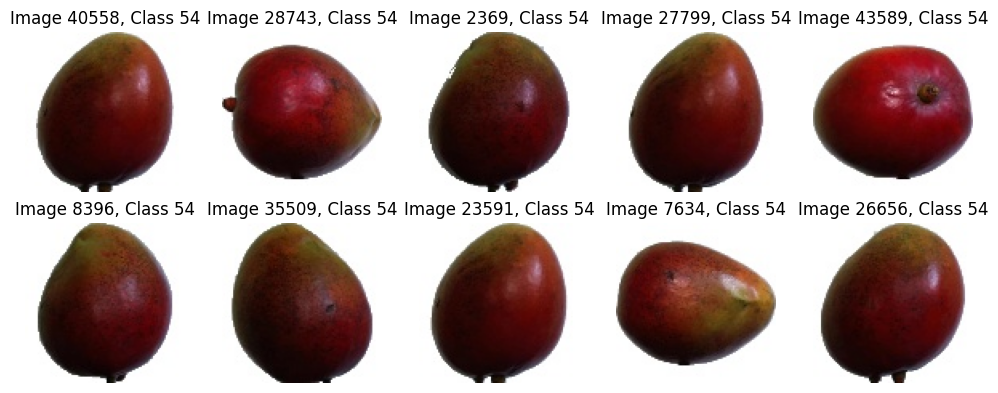

In [ ]:
# Выбираем класс для визуализации
class_id = 54

# Ищем индексы картинок, которые принадлежат конкретному классу
class_indices = np.where(train_labels == class_id)[0]

# Выбираем случайный набор
subset_indices = np.random.choice(class_indices, size=10, replace=False)

# Визуализируем набор
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for i, index in enumerate(subset_indices):
    row = i // 5
    col = i % 5
    ax[row, col].imshow(train_images[index])
    ax[row, col].axis('off')
    ax[row, col].set_title(f'Image {index}, Class {train_labels[index]}')
plt.tight_layout()
plt.show()

In [ ]:
# Убираем большую часть датасета для экономии RAM
train_images, train_labels = train_images[:15000], train_labels[:15000]

In [ ]:
# Используем функцию to_categorical для приведения
# классов к бинарному виду
train_labels = to_categorical(train_labels)

In [ ]:
# Разделяем датасет на две части 75%/25%
x_train,x_test,y_train,y_test = train_test_split(train_images,
                                                 train_labels,
                                                 test_size=0.25,
                                                 random_state=42)

In [ ]:
# Проверяем получившиеся наборы
x_train.shape

(11250, 100, 100, 3)

In [ ]:
x_test.shape

(3750, 100, 100, 3)

In [ ]:
# Разделяем вторую часть на валидационный и тестовый наборы
x_test,x_valid = x_test[2500:],x_test[:2500]
y_test,y_valid = y_test[2500:],y_test[:2500]
print('Validation images: ', x_valid.shape)
print('Validation labels:', y_valid.shape)
print('Test images: ', x_test.shape)
print('Test labels: ', y_test.shape)

Validation images:  (2500, 100, 100, 3)
Validation labels: (2500, 131)
Test images:  (1250, 100, 100, 3)
Test labels:  (1250, 131)


### Настройка модели для обучения

In [ ]:
# Выбираем архитектуру или конструируем самостоятельно

#odel = Sequential([                                            # создаем основу для нашей модели
#  Conv2D(num_filters, filter_size, input_shape=(100, 100, 3)),  # сверточный слой для анализа изображения
#  MaxPooling2D(pool_size=pool_size),                            # используем алгоритм для упрощения данных
#  Conv2D(num_filters*5, filter_size),                           # сверточный слой без указания входного размера
#  Dropout(0.3),                                                 # зануляем 30% связей между слоями
#  Flatten(),                                                    # создаем переход со сверточного слоя в полносвязный
#  Dense(512,activation='relu'),                                 # полносвязный слой
#  Dense(256,activation='relu'),                                 # полносвязный слой
#  Dense(131, activation='softmax'),                             # и добавляем выходной слой с кол-вом классов
#])

base_model = VGG16(include_top=False,   # убираем полносвязную часть классификации
                   input_shape=(100,100,3),   # выставляем входной слой
                   pooling='avg')   # алгоритм уменьшения карты признаков

In [ ]:
model = Sequential()  # создаем основу для нашей модели
model.add(base_model) # добавляем в нее предобученную часть

model.add(Dense(256,activation='relu'))     # добавляем полносвязный слой
model.add(Dense(131,activation='softmax'))  # и выходной слой с кол-вом классов

In [ ]:
# Анализируем архитектуру
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 131)               33667     
                                                                 
Total params: 14,879,683
Trainable params: 14,879,683
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Настраиваем аугментацию изображений
datagen = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        zoom_range = 0.1) # Например, увеличение картинок
datagen.fit(x_train)  # применяем трансформации

In [ ]:
# Добавляем "callback"и
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.2,
                      patience=3,
                      min_lr=0.001)
]

In [ ]:
# Добавляем настроенный оптимизатор
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 10       # кол-во эпох
batch_size = 128  # кол-во картинок в одной итерации (GPU VRAM)

In [ ]:
# Начинаем обучение!
History = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(x_valid,y_valid),
                              callbacks=callbacks_list, verbose=1,
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/10
87/87 [==============================] - 80s 629ms/step - loss: 4.6600 - accuracy: 0.0934 - val_loss: 3.1439 - val_accuracy: 0.2924 - lr: 1.0000e-04
Epoch 2/10
87/87 [==============================] - 38s 436ms/step - loss: 1.7102 - accuracy: 0.5851 - val_loss: 0.4682 - val_accuracy: 0.8652 - lr: 1.0000e-04
Epoch 3/10
87/87 [==============================] - 38s 438ms/step - loss: 0.3088 - accuracy: 0.9091 - val_loss: 0.2794 - val_accuracy: 0.9096 - lr: 1.0000e-04
Epoch 4/10
87/87 [==============================] - 39s 444ms/step - loss: 0.1183 - accuracy: 0.9632 - val_loss: 0.0355 - val_accuracy: 0.9912 - lr: 1.0000e-04
Epoch 5/10
87/87 [==============================] - 39s 448ms/step - loss: 0.0267 - accuracy: 0.9926 - val_loss: 0.0441 - val_accuracy: 0.9868 - lr: 1.0000e-04
Epoch 6/10
87/87 [==============================] - 40s 451ms/step - loss: 0.0515 - accuracy: 0.9838 - val_loss: 0.0430 - val_accuracy: 0.9860 - lr: 1.0000e-04
Epoch 7/10
87/87 [======================

### Проверка результатов

In [ ]:
# Проверяем точность модели на датасете тестирования
acc_score = model.evaluate(x_test, y_test)
print('\n', 'Test accuracy:', acc_score[1])

40/40 [==============================] - 3s 41ms/step - loss: 0.0213 - accuracy: 0.9936

 Test accuracy: 0.9936000108718872


In [ ]:
# Получаем наши классификации
pred = model.predict(x_test)
pred_digits = np.argmax(pred, axis=1)

40/40 [==============================] - 1s 31ms/step


In [ ]:
pred

array([[1.1436554e-08, 3.5784122e-16, 1.7303480e-08, ..., 2.2353835e-19,
        2.1637293e-12, 3.2258675e-11],
       [3.5724955e-17, 2.8093217e-23, 4.7769341e-14, ..., 9.2408711e-15,
        3.8637336e-16, 4.4540128e-13],
       [6.7684579e-13, 4.5247778e-14, 5.8940942e-12, ..., 1.2504502e-23,
        1.9307419e-19, 1.0006457e-15],
       ...,
       [3.0341520e-30, 1.8655730e-25, 3.2024145e-17, ..., 3.3835869e-16,
        2.8032999e-20, 1.3021375e-12],
       [5.1107870e-13, 6.2930244e-16, 1.5515901e-08, ..., 4.5196491e-13,
        3.8304616e-13, 2.2729130e-09],
       [3.6060928e-15, 4.0824155e-18, 4.8670425e-12, ..., 1.7987231e-13,
        1.2186912e-13, 3.1474075e-12]], dtype=float32)

In [ ]:
# Визуализируем
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==10):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==10):
        break

In [ ]:
# Словарь со всеми нашими классами
CLASS_LABELS = {0: 'Pear Forelle',
 1: 'Physalis with Husk',
 2: 'Blueberry',
 3: 'Lychee',
 4: 'Onion Red',
 5: 'Grape White',
 6: 'Grape Blue',
 7: 'Apple Crimson Snow',
 8: 'Apple Pink Lady',
 9: 'Cantaloupe 1',
 10: 'Mulberry',
 11: 'Plum 2',
 12: 'Lemon Meyer',
 13: 'Mangostan',
 14: 'Apple Red Delicious',
 15: 'Peach Flat',
 16: 'Potato Red Washed',
 17: 'Pepino',
 18: 'Salak',
 19: 'Apple Braeburn',
 20: 'Apple Golden 2',
 21: 'Onion Red Peeled',
 22: 'Cherry 1',
 23: 'Banana Lady Finger',
 24: 'Grape White 2',
 25: 'Grape White 4',
 26: 'Potato Sweet',
 27: 'Pineapple',
 28: 'Tomato not Ripened',
 29: 'Apple Golden 3',
 30: 'Tangelo',
 31: 'Granadilla',
 32: 'Pear Monster',
 33: 'Tomato 4',
 34: 'Chestnut',
 35: 'Limes',
 36: 'Hazelnut',
 37: 'Huckleberry',
 38: 'Grape White 3',
 39: 'Kohlrabi',
 40: 'Nectarine Flat',
 41: 'Pear Kaiser',
 42: 'Tomato Heart',
 43: 'Kiwi',
 44: 'Mandarine',
 45: 'Pepper Yellow',
 46: 'Pear 2',
 47: 'Redcurrant',
 48: 'Lemon',
 49: 'Apple Red 3',
 50: 'Physalis',
 51: 'Papaya',
 52: 'Plum 3',
 53: 'Pear Red',
 54: 'Mango Red',
 55: 'Cherry Wax Red',
 56: 'Plum',
 57: 'Corn Husk',
 58: 'Passion Fruit',
 59: 'Pear Abate',
 60: 'Ginger Root',
 61: 'Pineapple Mini',
 62: 'Cantaloupe 2',
 63: 'Pomelo Sweetie',
 64: 'Raspberry',
 65: 'Cucumber Ripe 2',
 66: 'Apple Red 2',
 67: 'Grapefruit White',
 68: 'Melon Piel de Sapo',
 69: 'Corn',
 70: 'Banana',
 71: 'Beetroot',
 72: 'Strawberry',
 73: 'Cocos',
 74: 'Pomegranate',
 75: 'Peach',
 76: 'Nut Forest',
 77: 'Apple Red Yellow 1',
 78: 'Pear Stone',
 79: 'Orange',
 80: 'Grapefruit Pink',
 81: 'Clementine',
 82: 'Nut Pecan',
 83: 'Apricot',
 84: 'Tomato Maroon',
 85: 'Onion White',
 86: 'Pepper Red',
 87: 'Cucumber Ripe',
 88: 'Strawberry Wedge',
 89: 'Kumquats',
 90: 'Guava',
 91: 'Apple Granny Smith',
 92: 'Carambula',
 93: 'Cherry Wax Black',
 94: 'Apple Red Yellow 2',
 95: 'Potato White',
 96: 'Avocado ripe',
 97: 'Tomato Yellow',
 98: 'Pear',
 99: 'Dates',
 100: 'Cherry Rainier',
 101: 'Pepper Green',
 102: 'Tomato 3',
 103: 'Quince',
 104: 'Maracuja',
 105: 'Tomato 1',
 106: 'Avocado',
 107: 'Pepper Orange',
 108: 'Pear Williams',
 109: 'Banana Red',
 110: 'Apple Golden 1',
 111: 'Tomato 2',
 112: 'Cherry 2',
 113: 'Apple Red 1',
 114: 'Cactus fruit',
 115: 'Cherry Wax Yellow',
 116: 'Kaki',
 117: 'Tamarillo',
 118: 'Nectarine',
 119: 'Eggplant',
 120: 'Potato Red',
 121: 'Tomato Cherry Red',
 122: 'Watermelon',
 123: 'Peach 2',
 124: 'Pitahaya Red',
 125: 'Walnut',
 126: 'Mango',
 127: 'Fig',
 128: 'Rambutan',
 129: 'Grape Pink',
 130: 'Cauliflower'}

In [ ]:
CLASS_LABELS[pred_digits[0]]  # одно из предсказаний

'Apricot'

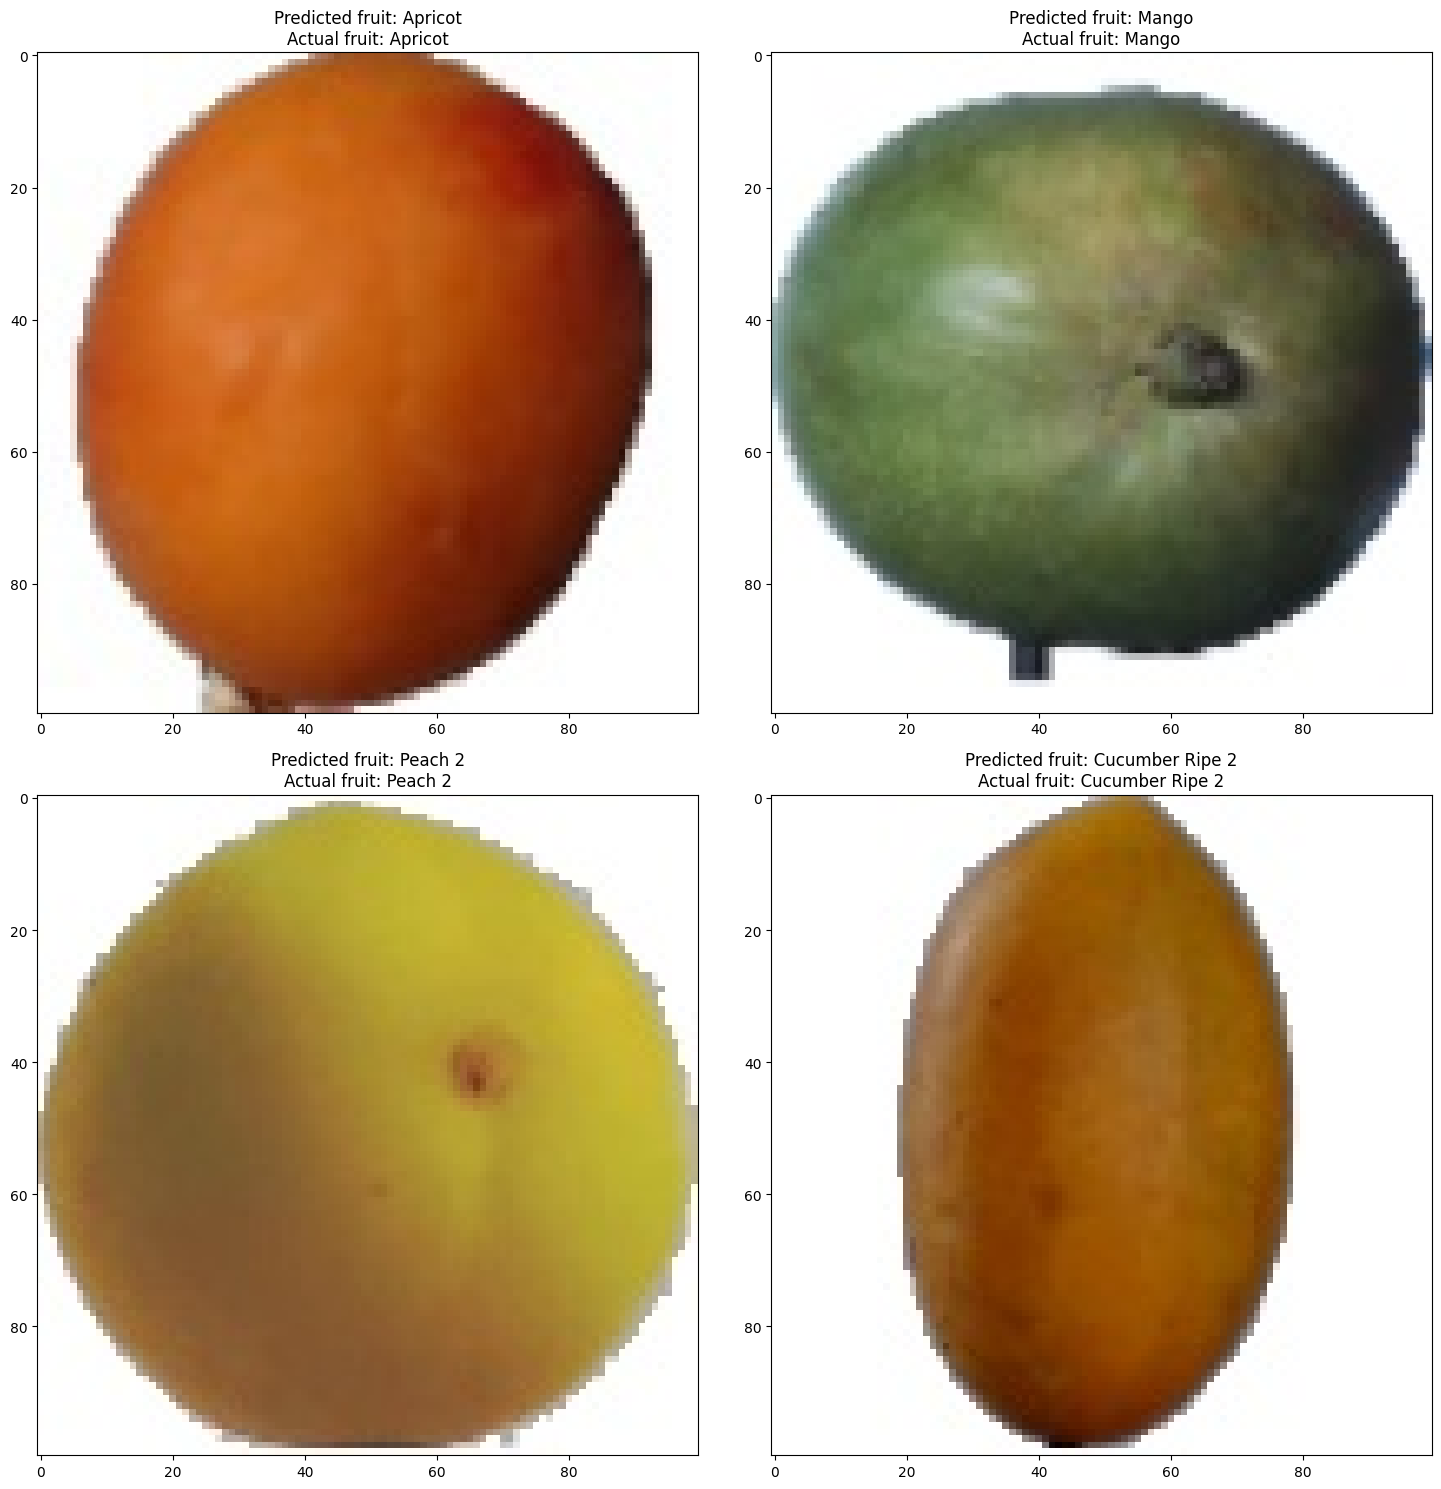

In [ ]:
# Правильные предсказания
count=0
fig,ax=plt.subplots(2,2)
fig.set_size_inches(15,15)
for i in range (2):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted fruit: "+ \
                          str(CLASS_LABELS[pred_digits[count]])+"\n"+ \
                          "Actual fruit: "+ \
                          str(CLASS_LABELS[np.argmax([y_test[prop_class[count]]])]))
        plt.tight_layout()
        count+=1

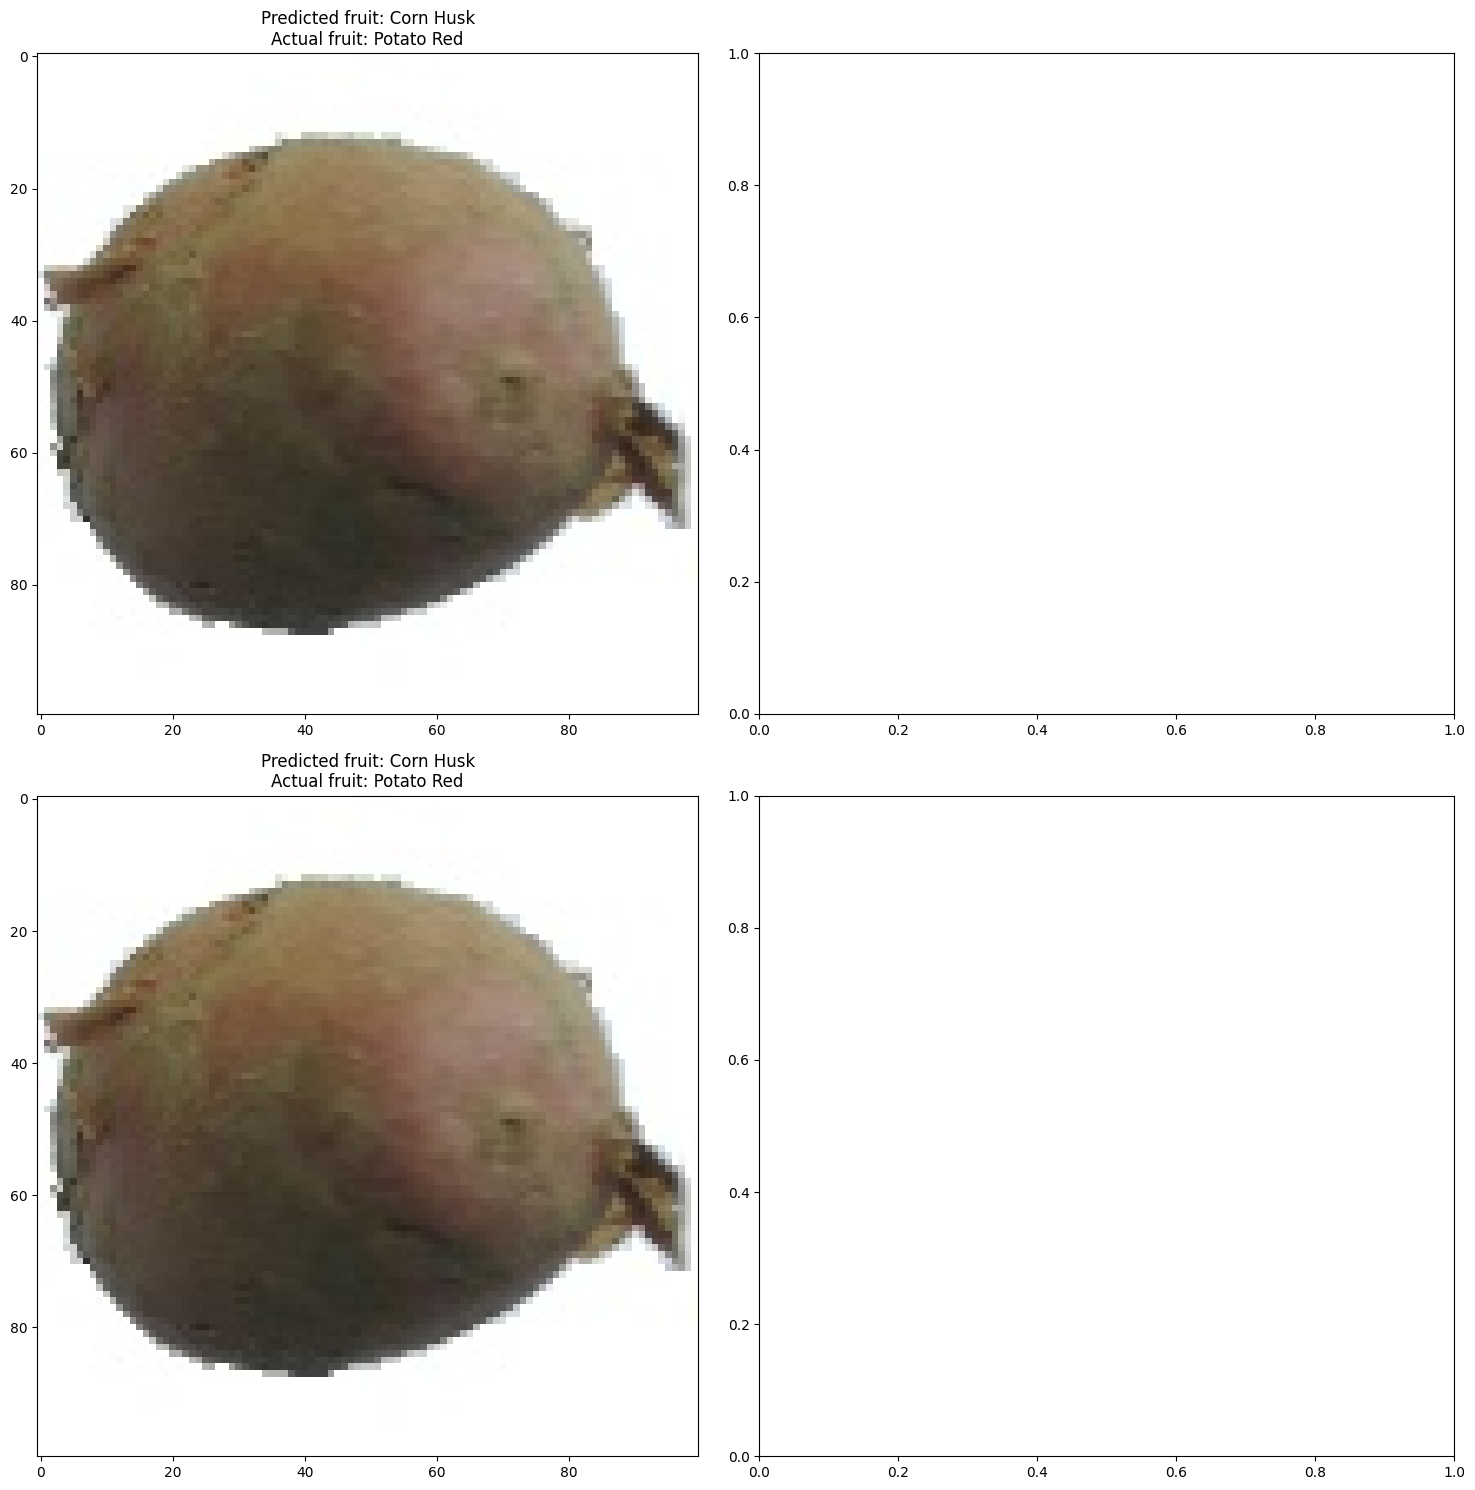

In [ ]:
# Неправильные предсказания (вполне может получиться так, что таких
# картинок немного и будет ошибка в блоке с циклом)
count=0
if len(mis_class) >= 4:
  fig,ax=plt.subplots(2,2)
elif len(mis_class) == 3:
  fig,ax=plt.subplots(2,1)
elif len(mis_class) == 2:
  fig,ax=plt.subplots(2,0)
else:
  fig,ax=plt.subplots(1,0)
fig.set_size_inches(15,15)

for i in range (2):
   for j in range (2):
      ax[i,j].imshow(x_test[mis_class[count]])
      ax[i,j].set_title("Predicted fruit: " + str(CLASS_LABELS[mis_class[count]])+"\n"+ \
                        "Actual fruit: "+ \
                        str(CLASS_LABELS[np.argmax([y_test[mis_class[count]]])]))
      plt.tight_layout()
      if len(mis_class) < count:
        count+=1
      else:
        break


### Тестируем нашу модель на датасете для Kaggle

In [ ]:
test_images = np.load("test_images.npy")

In [ ]:
# Запускаем классификатор на тестовых данных для Kaggle
pred_kaggle = model.predict(test_images)
H = [np.argmax(pred_kaggle[i]) for i in range(pred_kaggle.shape[0])]

# Библиотека для работы с табличными данными
import pandas as pd
df = pd.DataFrame(H, columns=['label'])
df.index.rename('image_id', inplace=True)
df = df.astype(int)
df.to_csv(r'kaggle.csv') # Сохранили файл с названием "kaggle.csv"

424/424 [==============================] - 12s 29ms/step


In [ ]:
!kaggle competitions submit -c deepcode-challenge-2023 -f kaggle.csv -m "First"

100% 111k/111k [00:02<00:00, 44.1kB/s]
Successfully submitted to DeepCode Challenge 2023